In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols

from bioreaction.simulation.manager import simulate_steady_states
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.testing.shared import CONFIG
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config

CONFIG = prepare_config(CONFIG)

In [3]:
fn = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
# data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
# dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)


## Mean & STDs

In [4]:
analytics = [c for c in get_true_names_analytics(data) if ('sensitivity' in c) or ('precision' in c)]
# agg1 = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: 'std' for c in analytics})
agg1_stds = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.std(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})
agg1_mean = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.mean(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})


In [5]:
agg1_stds.columns

Index(['circuit_name', 'mutation_num', 'sample_name',
       'precision_wrt_species-6',
       'precision_wrt_species-6_diff_to_base_circuit',
       'precision_wrt_species-6_ratio_from_mutation_to_base',
       'sensitivity_wrt_species-6',
       'sensitivity_wrt_species-6_diff_to_base_circuit',
       'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
       'num_interacting', 'num_self_interacting'],
      dtype='object')

In [6]:
# sns.jointplot(agg1_stds, x='precision_wrt_species-6', y='sensitivity_wrt_species-6', alpha=0.1)


In [7]:
# sns.jointplot(agg1_stds, x='precision_wrt_species-6', y='sensitivity_wrt_species-6', alpha=0.1)
# plt.xscale('log')

Find joint min of precision and std differences between all circuits and max of precision STD difference. Flip into a maximisation problem. 

Get circuit indices for filtered aggregated data and make dataframes for the chosen circuits.

In [8]:
filts = (agg1_mean['sample_name'] == 'RNA_2') & (agg1_mean['precision_wrt_species-6'] != np.inf) & (
    agg1_mean['precision_wrt_species-6'] > 1) & ((agg1_mean['num_interacting'] > 1) | (agg1_mean['num_self_interacting'] > 1))

p = agg1_mean[filts]['precision_wrt_species-6'].to_numpy()
s = agg1_mean[filts]['sensitivity_wrt_species-6'].to_numpy()
st = agg1_stds[filts]['precision_wrt_species-6_ratio_from_mutation_to_base'].to_numpy()

std_diffs = np.log(st[:, None] / st[None, :])
prec_diffs = np.log(p[:, None] / p[None, :])
sens_diffs = np.log(s[:, None] / s[None, :])

std_diffs = np.where(np.isnan(std_diffs) | (np.abs(std_diffs) == np.inf), 0, std_diffs)
weighting_prec = 1
weighting_sens = 1
weighting_stds = 0.1
joint_diffs = weighting_prec * np.abs(prec_diffs) + weighting_sens * np.abs(sens_diffs)
joint_diffs_rev = np.where(joint_diffs != 0, joint_diffs.max() - np.abs(joint_diffs), 0)
joint = joint_diffs_rev + weighting_stds * np.abs(std_diffs)

circ1, circ2 = np.where(joint == np.abs(joint).max()) 
circ1, circ2 = np.array(list(set([tuple(sorted([c1, c2])) for c1, c2 in zip(circ1, circ2)]))).T

circ1_m_df = agg1_mean[filts].iloc[circ1]
circ2_m_df = agg1_mean[filts].iloc[circ2]
circ1_s_df = agg1_stds[filts].iloc[circ1]
circ2_s_df = agg1_stds[filts].iloc[circ2]


/tmp/ipykernel_44940/1889599552.py:8: RuntimeWarning: divide by zero encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/tmp/ipykernel_44940/1889599552.py:8: RuntimeWarning: invalid value encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/tmp/ipykernel_44940/1889599552.py:8: RuntimeWarning: divide by zero encountered in log
  std_diffs = np.log(st[:, None] / st[None, :])


In [9]:
joint_diffs[joint_diffs != 0].min()

1.3309970863346284e-05

In [10]:
joint_diffs.max()

19.83108860230109

In [11]:
np.abs(std_diffs).max()

15.18527732397358

In [12]:
joint.max()

20.37223834058858

In [13]:
print(joint[circ1[0], circ2[0]])
print(joint_diffs_rev[circ1[0], circ2[0]])
print(joint_diffs[circ1[0], circ2[0]])
print(std_diffs[circ1[0], circ2[0]])
print(prec_diffs[circ1[0], circ2[0]])
print(sens_diffs[circ1[0], circ2[0]])

20.37223834058858
19.77736277270457
0.053725829596521245
-5.948755678840089
0.01291112297261983
-0.040814706623901416


In [14]:
circ2_m_df

,circuit_name,mutation_num,sample_name,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,num_interacting,num_self_interacting
28871,toy_circuit_combo0_720302,10,RNA_2,2264.547677,2252.43469,186.952456,0.052298,-0.016233,0.763131,1.1,0.333333


Narrow the selection.

In [15]:
data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ1_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == circ1_m_df['sample_name'].values[0]) ][
    ['circuit_name', 'mutation_name', 'mutation_num', 'mutation_type', 'mutation_positions', 'num_interacting', 'num_self_interacting', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base', 'sample_name']
]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,num_interacting,num_self_interacting,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,sample_name
735257,toy_circuit_combo0_712579,RNA_0_m10-0,10,"[1, 2, 1, 6, 1, 5, 5, 0, 8, 10]","[19, 14, 7, 15, 11, 16, 13, 0, 9, 18]",1,1,2805.63870,585.385500,1.263657,0.000356,-9.032962e-05,0.797809,RNA_2
735269,toy_circuit_combo0_712579,RNA_0_m10-4,10,"[6, 8, 0, 8, 10, 10, 9, 4, 5, 1]","[8, 4, 11, 9, 2, 18, 3, 1, 13, 14]",1,0,2790.69040,570.437260,1.256924,0.000356,-9.048288e-05,0.797466,RNA_2
735275,toy_circuit_combo0_712579,RNA_0_m10-6,10,"[2, 2, 5, 10, 0, 3, 6, 2, 0, 4]","[7, 19, 13, 3, 10, 1, 15, 0, 11, 16]",0,1,2922.29400,702.040800,1.316199,0.000544,9.717405e-05,1.217511,RNA_2
735281,toy_circuit_combo0_712579,RNA_0_m10-8,10,"[8, 6, 3, 1, 4, 2, 5, 0, 2, 6]","[4, 15, 13, 19, 1, 11, 16, 0, 14, 6]",0,1,2959.16100,738.907700,1.332803,0.000338,-1.088211e-04,0.756419,RNA_2
735284,toy_circuit_combo0_712579,RNA_0_m10-9,10,"[6, 8, 9, 3, 1, 2, 0, 5, 8, 8]","[8, 4, 18, 16, 11, 19, 14, 1, 6, 15]",1,0,2985.76440,765.511200,1.344785,0.000335,-1.118321e-04,0.749679,RNA_2
735437,toy_circuit_combo0_712579,RNA_1_m10-0,10,"[0, 3, 7, 3, 10, 1, 11, 4, 3, 6]","[4, 1, 15, 0, 19, 18, 3, 17, 14, 9]",1,1,2780.55080,560.297600,1.252358,0.000357,-9.002327e-05,0.798495,RNA_2
735440,toy_circuit_combo0_712579,RNA_1_m10-1,10,"[4, 8, 7, 9, 3, 10, 7, 8, 4, 10]","[16, 9, 5, 3, 14, 10, 7, 13, 1, 19]",0,1,2220.25320,0.000000,1.000000,0.000447,0.000000e+00,1.000000,RNA_2
735446,toy_circuit_combo0_712579,RNA_1_m10-3,10,"[4, 1, 8, 2, 1, 7, 3, 5, 5, 8]","[11, 6, 7, 4, 2, 15, 14, 0, 1, 9]",1,1,2222.97340,2.720215,1.001225,0.000446,-5.706970e-07,0.998723,RNA_2
735449,toy_circuit_combo0_712579,RNA_1_m10-4,10,"[7, 1, 3, 3, 7, 11, 6, 10, 1, 5]","[8, 2, 11, 1, 5, 12, 15, 19, 18, 14]",2,1,1336.32230,-883.930900,0.601878,0.000742,2.954264e-04,1.661272,RNA_2
735452,toy_circuit_combo0_712579,RNA_1_m10-5,10,"[7, 8, 4, 0, 11, 4, 5, 0, 7, 6]","[7, 13, 17, 18, 3, 0, 1, 6, 9, 5]",1,1,1973.22790,-247.025270,0.888740,0.000489,4.268417e-05,1.095543,RNA_2


In [16]:

data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ2_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == circ2_m_df['sample_name'].values[0]) ][
    ['circuit_name', 'mutation_name', 'mutation_num', 'mutation_type', 'mutation_positions', 'num_interacting', 'num_self_interacting', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base', 'sample_name']
]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,num_interacting,num_self_interacting,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,sample_name
746126,toy_circuit_combo0_720302,RNA_0_m10-3,10,"[5, 5, 10, 10, 2, 9, 4, 3, 6, 6]","[15, 8, 6, 16, 10, 18, 17, 3, 14, 12]",1,0,3496.90750,3484.7944,288.691400,0.000286,-0.068245,0.004173,RNA_2
746138,toy_circuit_combo0_720302,RNA_0_m10-7,10,"[7, 9, 3, 5, 6, 8, 6, 3, 3, 10]","[19, 2, 17, 3, 12, 5, 14, 13, 15, 6]",1,0,3496.90750,3484.7944,288.691400,0.000286,-0.068245,0.004173,RNA_2
746141,toy_circuit_combo0_720302,RNA_0_m10-8,10,"[5, 6, 0, 5, 10, 5, 9, 8, 0, 7]","[3, 9, 7, 13, 18, 17, 6, 12, 10, 5]",1,0,3496.90750,3484.7944,288.691400,0.000286,-0.068245,0.004173,RNA_2
746144,toy_circuit_combo0_720302,RNA_0_m10-9,10,"[6, 11, 8, 8, 2, 4, 9, 7, 5, 2]","[4, 18, 12, 5, 10, 15, 6, 9, 1, 7]",1,1,3375.27660,3363.1636,278.650020,0.000296,-0.068234,0.004323,RNA_2
746297,toy_circuit_combo0_720302,RNA_1_m10-0,10,"[8, 10, 9, 8, 6, 1, 6, 9, 4, 7]","[2, 19, 6, 7, 17, 18, 16, 5, 10, 12]",0,1,2985.30760,2973.1946,246.455660,0.000335,-0.068196,0.004888,RNA_2
746300,toy_circuit_combo0_720302,RNA_1_m10-1,10,"[4, 8, 10, 8, 8, 10, 5, 10, 8, 1]","[1, 12, 11, 17, 7, 5, 15, 0, 2, 18]",1,0,2810.27980,2798.1667,232.006030,0.000354,-0.068176,0.005172,RNA_2
746303,toy_circuit_combo0_720302,RNA_1_m10-2,10,"[7, 5, 9, 5, 0, 6, 7, 5, 6, 10]","[7, 15, 11, 1, 18, 2, 17, 10, 9, 6]",1,1,2547.59810,2535.4850,210.320020,0.000378,-0.068153,0.005513,RNA_2
746306,toy_circuit_combo0_720302,RNA_1_m10-3,10,"[4, 0, 10, 9, 11, 7, 8, 5, 7, 8]","[15, 18, 11, 8, 5, 16, 2, 10, 13, 4]",1,1,2896.22630,2884.1133,239.101440,0.000345,-0.068186,0.005035,RNA_2
746312,toy_circuit_combo0_720302,RNA_1_m10-5,10,"[2, 3, 11, 11, 8, 6, 11, 11, 7, 8]","[18, 15, 19, 3, 4, 14, 5, 8, 7, 2]",2,1,854.20325,842.0903,70.519775,0.001171,-0.067360,0.017083,RNA_2
746321,toy_circuit_combo0_720302,RNA_1_m10-8,10,"[7, 8, 11, 4, 11, 11, 3, 7, 6, 0]","[16, 7, 19, 1, 5, 8, 15, 2, 14, 18]",0,1,2984.88870,2972.7756,246.421080,0.000335,-0.068196,0.004889,RNA_2


In [17]:
# circuit_chosen_idx = circ1[0]
# circuit_chosen = data.iloc[circuit_chosen_idx]
# e_dir = os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', circuit_chosen['circuit_name'], 'mutations', circuit_chosen['mutation_name'], 'energies')
# energies = pd.read_csv(os.path.join(e_dir, os.listdir(e_dir)[0]))
# print(circuit_chosen[['circuit_name', 'mutation_name']])
# energies

## Check circuits chosen

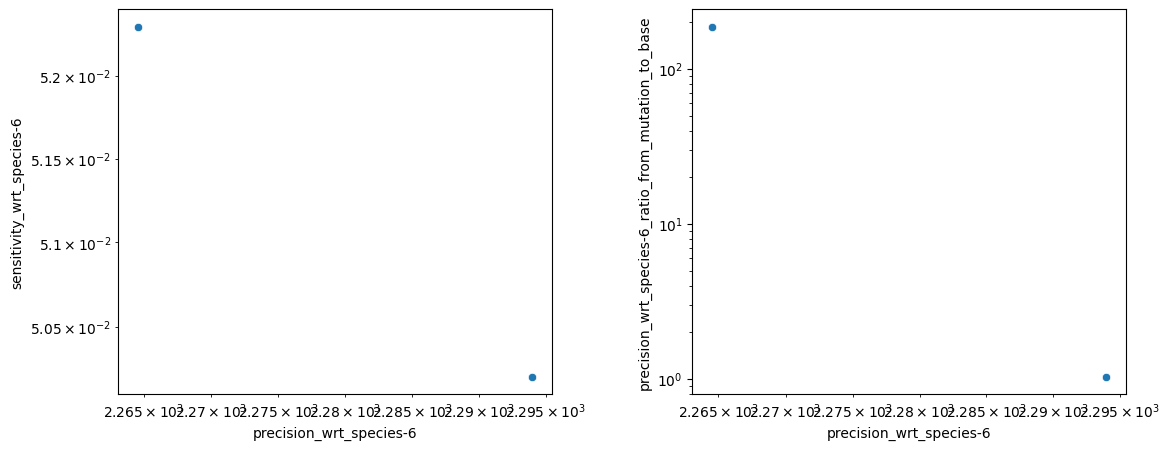

In [18]:


m_df = pd.concat([circ1_m_df, circ2_m_df])
s_df = pd.concat([circ1_m_df, circ2_m_df])

fig =plt.figure(figsize=(13, 5))
fig.subplots_adjust(wspace=0.325)

ax = plt.subplot(1,2,1)
sns.scatterplot(x=m_df['precision_wrt_species-6'], y=m_df['sensitivity_wrt_species-6'])
plt.yscale('log')
plt.xscale('log')
ax = plt.subplot(1,2,2)
sns.scatterplot(x=s_df['precision_wrt_species-6'], y=s_df['precision_wrt_species-6_ratio_from_mutation_to_base'])
plt.yscale('log')
plt.xscale('log')


Text(0.5, 0.98, 'Precision mean for $RNA_2$')

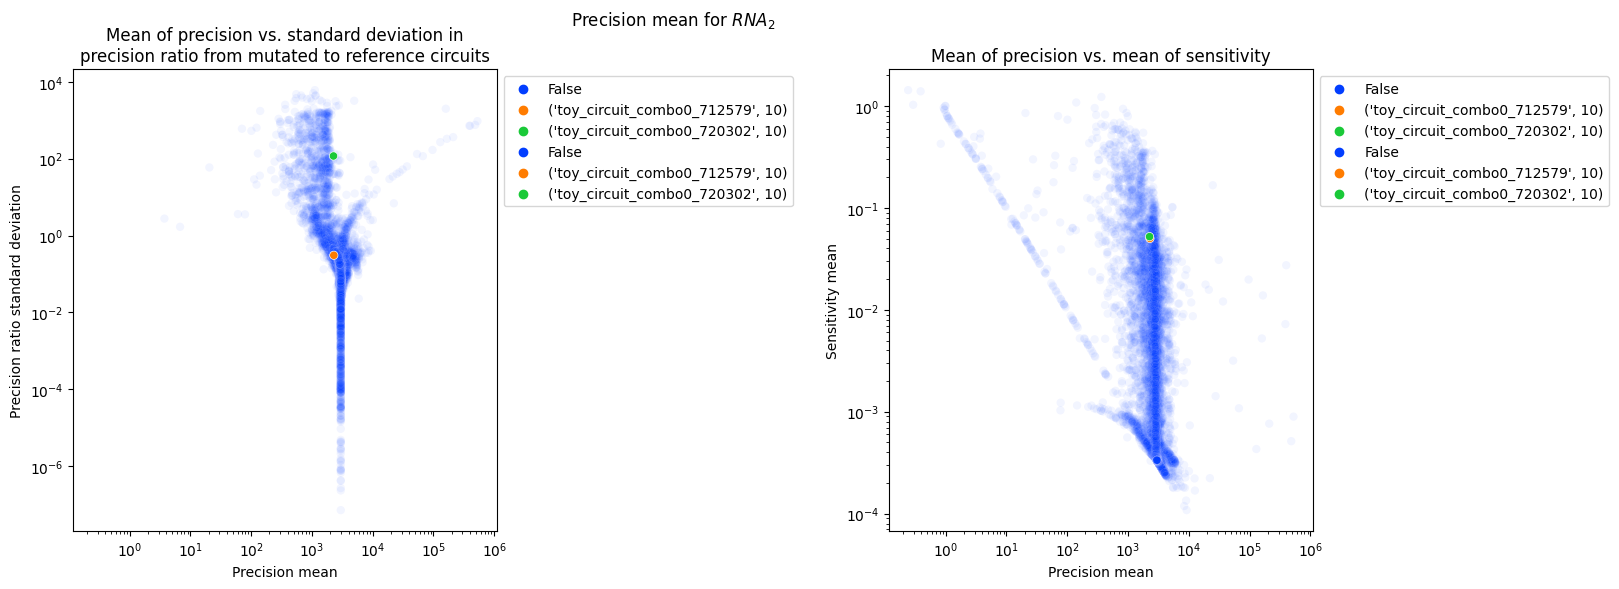

In [19]:

filt = (agg1_mean['precision_wrt_species-6'] < np.inf) & (agg1_mean['sample_name'] == 'RNA_2')
c1n, c1m = circ1_m_df['circuit_name'].values[0], circ1_m_df['mutation_num'].values[0]
c2n, c2m = circ2_m_df['circuit_name'].values[0], circ2_m_df['mutation_num'].values[0]
hue_d = {c1n: c1m, c2n: c2m}
# hue = jax.tree_util.tree_map(lambda c, m: (c,m) if (c in [c1n, c2n]) and (m == hue_d[c]) else False, list(agg1_mean[filt]['circuit_name'].values), list(agg1_mean[filt]['mutation_num'].values))
hue = list(map(lambda i, c, m: (c, m) if (i == circ1_m_df.index[0]) or (i == circ2_m_df.index[0]) else False, 
               list(agg1_mean[filt].index), list(agg1_mean[filt]['circuit_name'].values), list(agg1_mean[filt]['mutation_num'].values)))
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(wspace=0.925)

ax = plt.subplot(1,2,1)
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_stds[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=0.05,
                hue=hue,
                palette='bright')
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_stds[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('Precision ratio standard deviation')
plt.xscale('log')
plt.yscale('log')
plt.title('Mean of precision vs. standard deviation in\nprecision ratio from mutated to reference circuits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

filt = (agg1_mean['precision_wrt_species-6'] < np.inf) & (agg1_mean['sensitivity_wrt_species-6'] < np.inf) & (agg1_mean['sample_name'] == 'RNA_2')
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

ax = plt.subplot(1,2,2)
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_mean[filt]['sensitivity_wrt_species-6'], 
                alpha=0.05,
                hue=hue,
                palette="bright")
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_mean[filt]['sensitivity_wrt_species-6'], 
                alpha=alpha,
                hue=hue,
                palette="bright")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precision mean')
plt.ylabel('Sensitivity mean')
plt.title('Mean of precision vs. mean of sensitivity')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

plt.suptitle('Precision mean for $RNA_2$')



In [20]:
np.log10(agg1_mean[(agg1_mean['circuit_name'].isin([c1n, c2n])) & (agg1_mean['mutation_num'].isin([c1m, c2m])) & (agg1_mean['sample_name'] == 'RNA_2')]['precision_wrt_species-6'])

28451    3.360589
28871    3.354981
Name: precision_wrt_species-6, dtype: float64

## Load circuits

In [28]:

og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'

def load_circuit(circ_row, config):

    def symmetrical_matrix_length(flattened_length):
        return int((-1 + np.sqrt(1 + 8 * flattened_length)) / 2)

    def flatten_to_matrix(flattened_vector):
        length = symmetrical_matrix_length(len(flattened_vector))
        if length == 1:
            length = int(np.sqrt(len(flattened_vector)))
            return flattened_vector.reshape((length, length))
        
        matrix = [[0] * length for _ in range(length)]
        index = 0
        for i in range(length):
            for j in range(i, length):
                matrix[i][j] = flattened_vector[index]
                matrix[j][i] = flattened_vector[index]
                index += 1
        return np.array(matrix)
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')].values.squeeze()),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')].values.squeeze()),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')].values.squeeze()),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')].values.squeeze())}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

def batch_load(circ_rows: pd.DataFrame, ref_c: pd.DataFrame):
    circuits = []
    circuits.append(load_circuit(circ_row=ref_c.iloc[0], config=CONFIG))
    for i, circ_row in circ_rows.iterrows():
        circuits.append(load_circuit(circ_row=circ_row, config=CONFIG))
    return circuits

circ_rows1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ1_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_0')]
ref_c1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_0')]
circ_rows2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ2_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_0')]
ref_c2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_0')]
circuits1 = batch_load(circ_rows1, ref_c1)
circuits2 = batch_load(circ_rows2, ref_c2)
circuits = circuits1 + circuits2

forward_rates = circuits1[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])

t0 = 0 
t1 = 200
dt = 0.001
tmax = 5000
threshold_steady_states = 0.005

signal_onehot = np.zeros_like(circuits1[0].signal.reactions_onehot) if circuits1[0].use_prod_and_deg else np.zeros_like(circuits1[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits1[0].qreactions.reactions.inputs,
                            outputs=circuits1[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, 5000))
                            )))


### Simulate

In [ ]:

config = load_json_as_dict(os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
config = config['config_filepath']
signal_target = config['signal']['function_kwargs']['target']
signal_target

In [31]:


signal = circuits[0].signal
signal_target = signal.func.keywords['target']

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits])
b_copynumbers, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)

signal_species = 'RNA_0'
signal_species_idx = np.where(circuits1[0].signal.onehot)[0][0]

b_steady_states = b_copynumbers[:, :, -1]
# b_steady_states[:, signal_species_idx] += b_copynumbers[:, signal_species_idx, 0] * signal_target

b_steady_states = (b_copynumbers[:, :, -1] * ((signal.onehot == 0) * 1)) + \
    (b_copynumbers[:, :, 0] *
     signal_target) * signal.onehot


Done:  0:01:11.327701


In [ ]:

b_new_copynumbers, tyy = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)

### Visualise

In [32]:
len(circuits)

40

Text(0.5, 0.98, 'Circuit traces: reference and mutations')

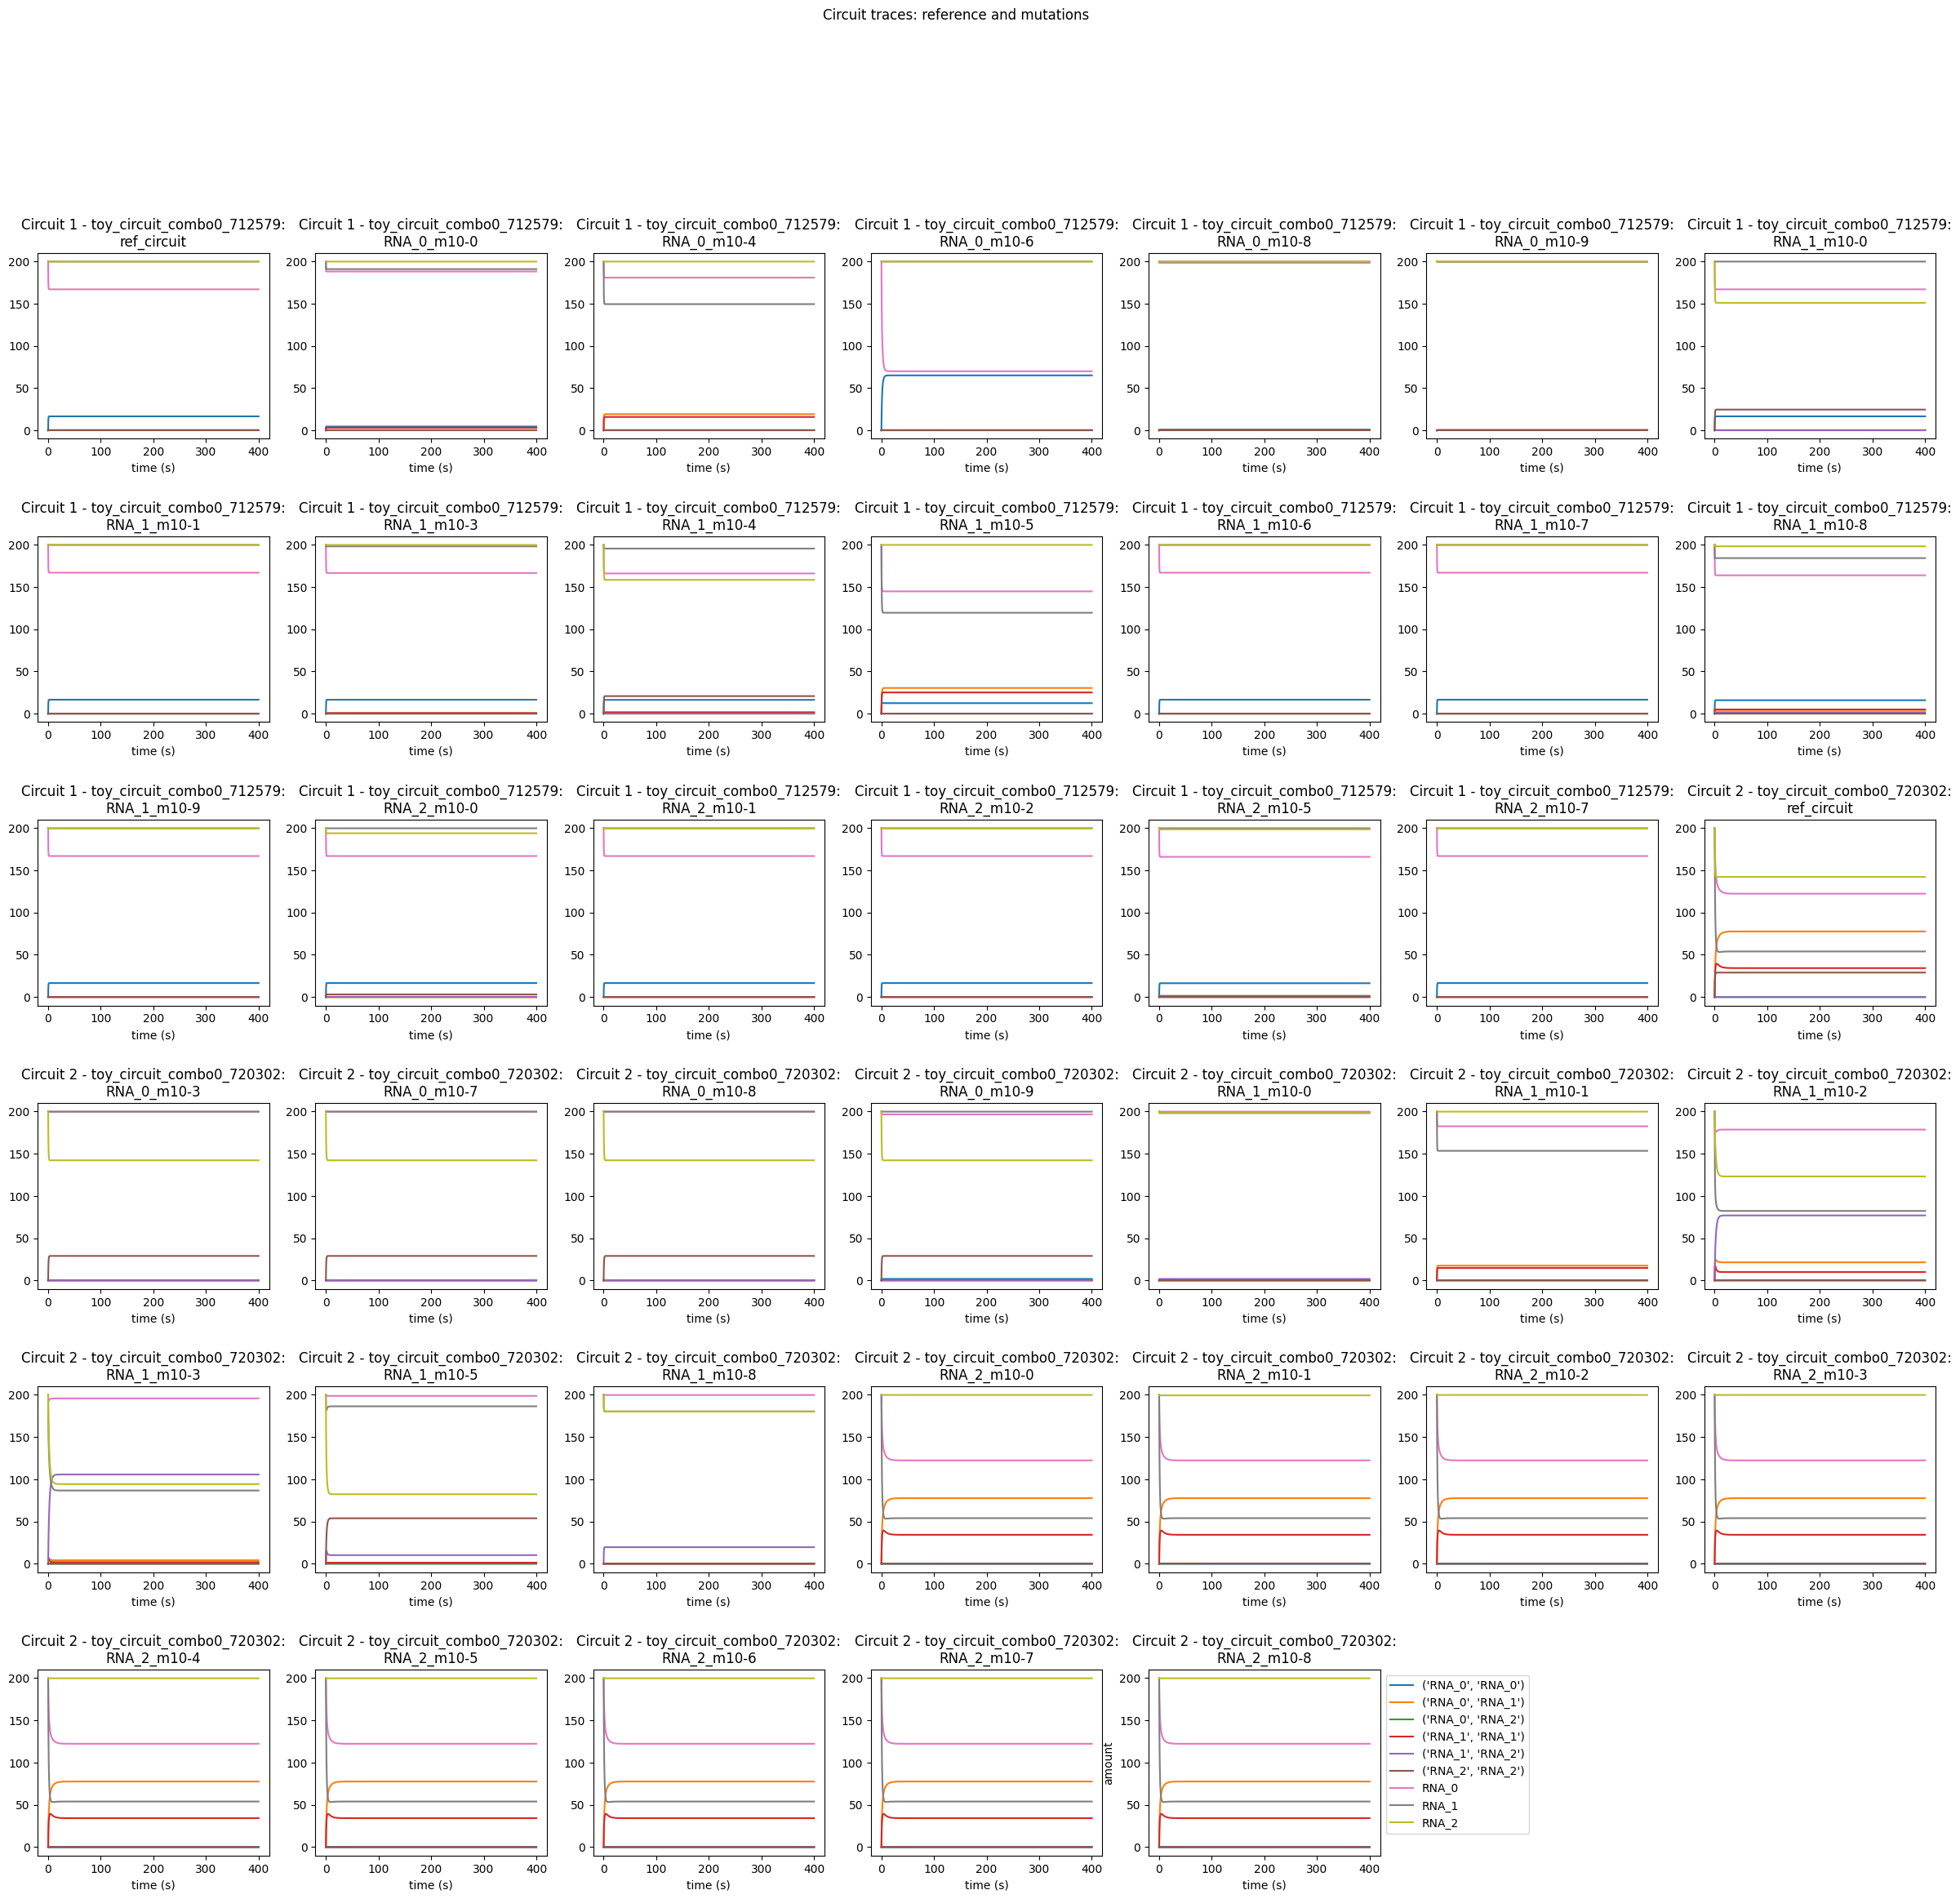

In [33]:
num_circuits = len(circuits)
nm=0
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=0.525)
for i, circ in enumerate(circuits):
    ax = plt.subplot(7,7,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]))
    circ_type = 'Circuit 2' if circ in circuits2 else 'Circuit 1'
    plt.title(f'{circ_type} - {circuits[i].name}:\n{circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')


### Zoomed in at beginning of time trace

Text(0.5, 0.98, 'Circuit traces: reference and mutations')

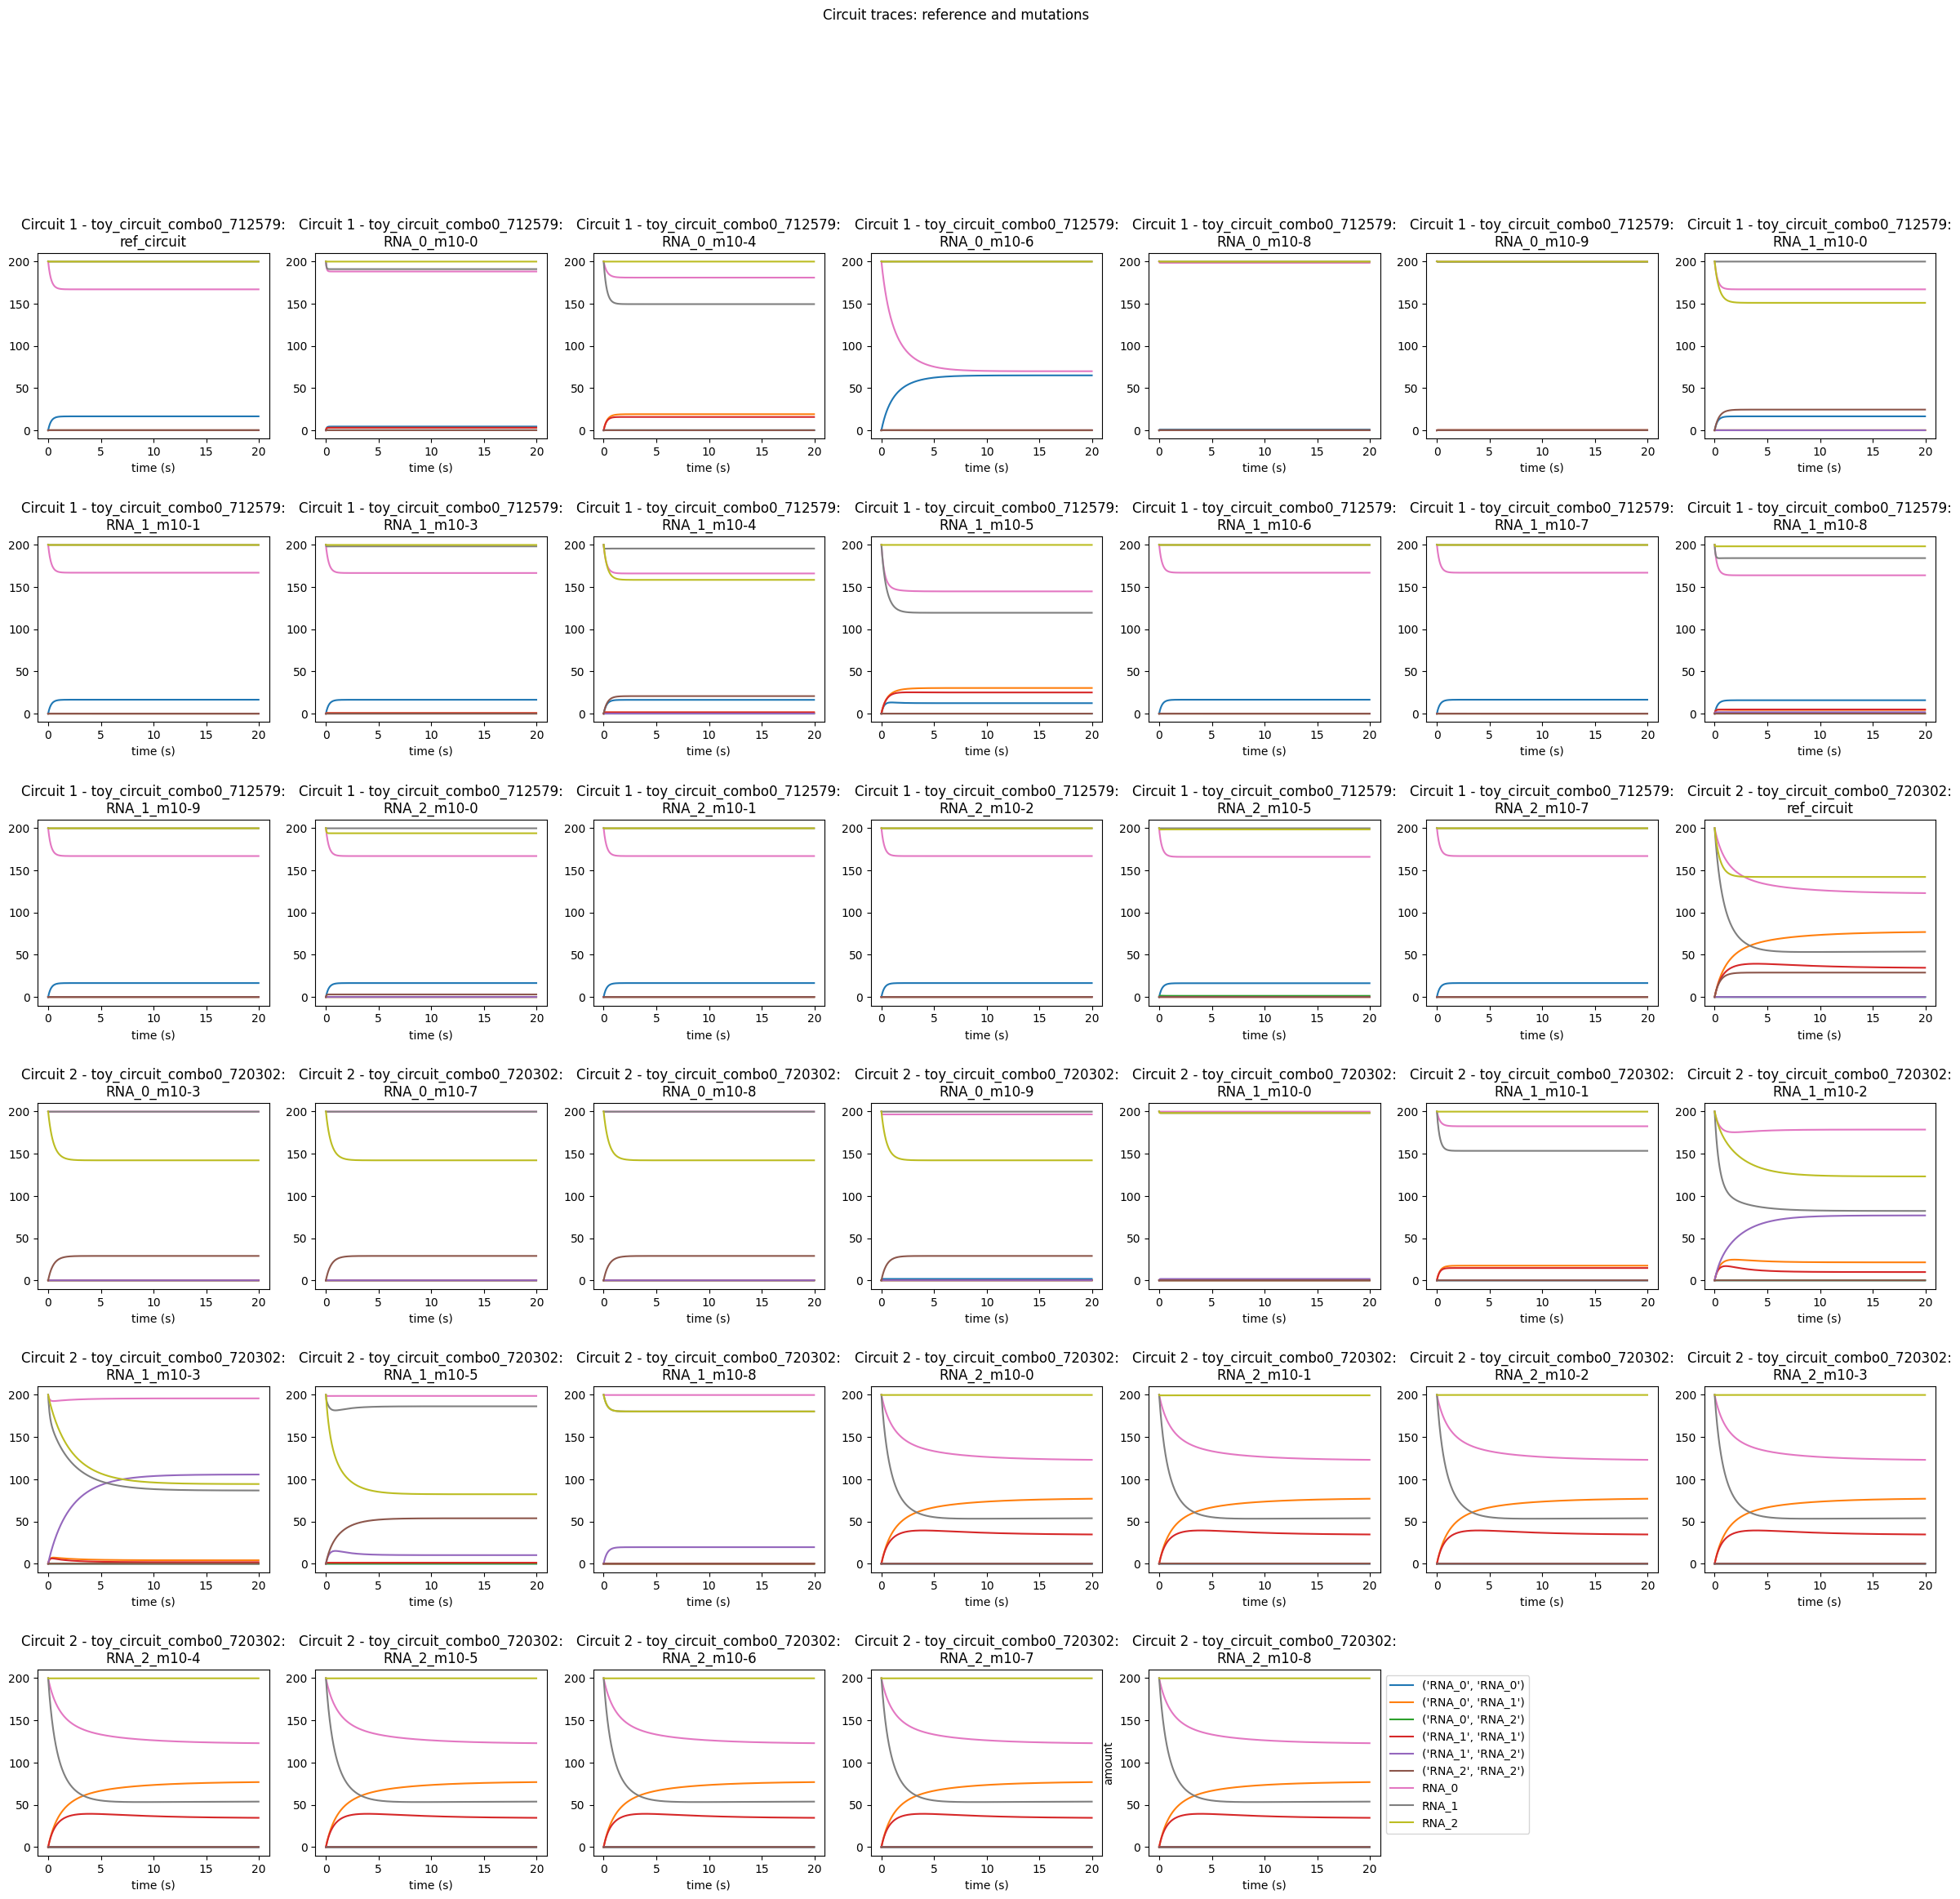

In [35]:
num_circuits = len(circuits)
nm=0
tdisplay = 500
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=0.525)
for i, circ in enumerate(circuits):
    ax = plt.subplot(7,7,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]])[:tdisplay], np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T])[:tdisplay])
    circ_type = 'Circuit 2' if circ in circuits2 else 'Circuit 1'
    plt.title(f'{circ_type} - {circuits[i].name}:\n{circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')
